In [1]:
numRows = 10                # SOM lentelės eilučių skaičius
numCols = 10                # SOM lentelės stulpelių skaičius
learningRate = 0.2      # Pradinis mokymo parametras
epochs = 400                 # Epochų skaičius
maxManhatanDistance = 4           # Pradinis Manheteno atstumas
fileName = 'iris.data'       # Duomenų failo pavadinimas

In [2]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from matplotlib import colors

In [3]:
# Irisų duomenų aibėje išmetamos Iris-setosa klasės reikšmės, kad būtų galima apdoroti Iris-versicolor, Iris-virginica, kaip 0 ir 1,
# po to duomenys sumaišomi, paskutinis stulpelis(klasės reikšmė) perkeliama į atskirą masyva) ir išmetama.
def prepareIrisData(inputFile: str) -> (np.ndarray, [int]):
    outputFile= inputFile.replace('.data', '2.csv')
    with open(inputFile, 'r') as fileInput:
        with open(outputFile, 'w') as file:
            for row in fileInput:
                modifiedString = row.replace('Iris-versicolor', '0').replace('Iris-virginica', '1').replace('Iris-setosa', '2')
                file.write(modifiedString)
    inputData = readDataFromFile(outputFile, 0)
    np.random.shuffle(inputData)
    output = inputData[:, -1]
    inputData = np.delete(inputData, -1, axis=1)
    # inputData = np.concatenate((np.array([1 for _ in range(inputData.shape[0])])[:, np.newaxis], inputData), axis=1)
    return inputData, output

def readDataFromFile(filename: str, skipRows: int = 1) -> np.ndarray:
    return np.loadtxt(filename, delimiter=',',skiprows=skipRows)



In [4]:
def euclideanDistance(x: np.array, y: np.array) -> float:
    return np.sqrt(np.sum(np.power(x - y, 2)))

def manhattanDistance(x: np.array, y: np.array) -> float:
    return np.sum(np.abs(x - y))

def normalizeData(data: np.ndarray) -> np.ndarray:
    return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

#figure out this and how it works
# Neurono-nugalėtojo paieška
def winningNeuron(data, t, som, numRows, numCols):
  winner = [0,0]
  shortestDistance = np.sqrt(data.shape[1])  # Kintamasis pradžioje inicializuojamas didžiausiu įmanomu atstumu
  for row in range(numRows):
    for col in range(numCols):
      distance = euclideanDistance(som[row][col], data[t])
      if distance < shortestDistance:
        shortestDistance = distance
        winner = [row,col]
  return winner

# figure out this and how it works
# Didėjant epochos skaičiui apskaičiuojamas vis mažesnis mokymo parametras ir
# didžiausias leistinas Manheteno atstumas, kuriuo kaimynai nutolę nuo
# neurono-nugalėtojo
def decay(step, epochs,learningRate,maxManhatanDistance):
  coefficient = 1.0 - (np.float64(step)/epochs)
  learningRate = coefficient * learningRate
  neighbourhoodRange = ceil(coefficient * maxManhatanDistance)
  return learningRate, neighbourhoodRange

def SOMTraining(irisData, epochs:int, learningRate:float, maxManhatanDistance:int, som: np.ndarray, numRows: int, numCols: int):
  for epoch in range(epochs):
    learningRate, neighbourhoodRange = decay(epoch, epochs, learningRate, maxManhatanDistance)
    for t in range(irisData.shape[0]):
      winner = np.array(winningNeuron(irisData, t, som, numRows, numCols)) # Randamas neuronas-nugalėtojas duotam vektoriui

      # Atnaujinami neuronų svoriai
      # Naudojama burbuliuko kaimynystės funkcija, kur atnaujinami tik į
      # neurono-nugalėtojo kaimynus patenkančių vektorių svoriai
      for row in range(numRows):
        for col in range(numCols):
          if manhattanDistance(np.array([row,col]),winner) <= neighbourhoodRange:
            som[row][col] += learningRate * (irisData[t] - som[row][col])

  return som

def drawMap(map, numRows, numCols):
  # Kiekviename langelyje parenkama vaizduoti ta klasė, kuri pasikartoja
  # dažniausiai tame langelyje
  labelMap = np.zeros(shape=(numRows, numCols), dtype=np.int16)
  for row in range(numRows):
    for col in range(numCols):
      labelList = map[row][col]
      if len(labelList) == 0:
        label = 3
      else:
        label = max(labelList, key=labelList.count)
      labelMap[row][col] = label

  cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange', 'w'])
  colorMap = plt.imshow(labelMap, cmap=cmap)

  labels = ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica', 'No class')
  cbar = plt.colorbar(colorMap, ticks=range(4))
  cbar.ax.set_yticklabels(labels)

  plt.show()


In [5]:
irisData, irisOutput = prepareIrisData('iris.data')
irisData = normalizeData(irisData)
irisData = np.array(irisData)
irisOutput = np.array(irisOutput)
print (irisOutput)

[0. 1. 0. 2. 1. 1. 2. 2. 0. 0. 0. 2. 2. 1. 1. 2. 2. 1. 2. 1. 0. 2. 2. 2.
 0. 1. 0. 0. 2. 1. 2. 2. 2. 2. 2. 0. 1. 2. 1. 1. 0. 1. 2. 0. 1. 0. 0. 2.
 0. 1. 1. 0. 1. 0. 0. 2. 2. 0. 2. 1. 1. 0. 1. 0. 2. 2. 0. 0. 0. 1. 1. 1.
 0. 1. 1. 2. 1. 1. 2. 2. 0. 2. 0. 1. 1. 0. 2. 1. 2. 0. 0. 0. 1. 1. 0. 2.
 1. 0. 2. 2. 1. 2. 0. 1. 2. 1. 1. 0. 1. 1. 1. 0. 2. 2. 0. 2. 1. 2. 2. 2.
 2. 1. 2. 0. 1. 0. 0. 0. 2. 2. 1. 1. 0. 1. 0. 2. 0. 2. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 2. 2. 0.]


In [6]:
# Inicializuojama matrica su atsitikinėmis vektorių reikšmėmis
numDimensions = irisData.shape[1]
np.random.seed(40)
som = np.random.random_sample(size=(numRows, numCols, numDimensions))
som = SOMTraining(irisData, epochs, learningRate, maxManhatanDistance, som, numRows, numCols)

In [7]:
# Apmokytas SOM priskiria kiekvieno įeities vektoriaus klasę žemėlapio vietai,
# kurioje yra neuronas-nugalėtojas

labelData = irisOutput
map = np.empty(shape=(numRows, numCols), dtype=object)
quantizationError = 0

for row in range(numRows):
  for col in range(numCols):
    map[row][col] = []

for t in range(irisData.shape[0]):
  winner = winningNeuron(irisData, t, som, numRows, numCols)
  map[winner[0]][winner[1]].append(irisOutput[t])
  quantizationError += euclideanDistance(irisData[t], som[winner[0]][winner[1]])

In [8]:
# Apskaičiuojama kvantavimo paklaida
quantizationError /= irisData.shape[0]
print("Quantization error: ", quantizationError)

Quantization error:  0.11311284069222609


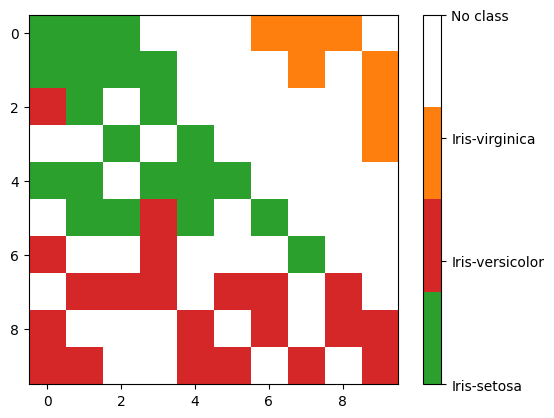

In [9]:
drawMap(map, numRows, numCols)